# 7-6. 프로젝트: 고양이 수염 스티커 만들기

주요 라이브러리 호출

In [1]:
# 필요한 패키지 import 하기
import os # 환경 변수나 디렉터리, 파일 등의 OS 자원을 제어할 수 있게 해주는 모듈
import cv2 # OpenCV라이브러리 → 컴퓨터 비전 관련 프로그래밍을 쉽게 할 수 있도록 도와주는 라이브러리
import matplotlib.pyplot as plt # 다양한 데이터를 많은 방법으로 도식화 할 수 있도록 하는 라이브러리
import numpy as np # 다차원 배열을 쉽게 처리하고 효율적으로 사용할 수 있도록 하는 라이브러리
import dlib # 이미지 처리 및 기계 학습, 얼굴인식 등을 할 수 있는 c++ 로 개발된 고성능의 라이브러리

# Google Drive - Colab  연동을 위한 라이브러리 Import
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/Exploration/data'

Mounted at /content/drive


## Step 1. 스티커 구하기 or 만들기

- 고양이 수염 이미지
- 셀카

-> google drive에 저장 완료

---
## Step 2. 얼굴 검출 & 랜드마크 검출 하기

- 오늘 배운 dlib을 이용해서 얼굴의 bounding box 위치와 landmark의 위치를 찾아주세요.

---
### 사진 준비

이미지 load 후 확인해보자

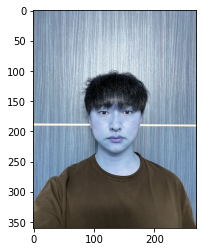

In [2]:
my_image_path = data_dir+'/camera_sticker/images/image.png' # 본인 이미지가 있는 경로를 가지고 온다.
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr) # 이미지를 출력하기 위해 출력할 이미지를 올려준다. (실제 출력은 하지 않음)
plt.show() # 이미지를 출력해준다. (실제 출력)

이미지가 푸른 이유 -> opencv의 특징 때문  
matplot lib, dlib 등의 이미지 라이브러리는 이미지 채널을 RGB 순서로 사용하는데, opencv는 BGR 순서로 사용하기 때문.  
R ─ B  **v**    
G ─ G    
B ─ R  **v**  

따라서 원본 사진에서 붉은색은 푸른색으로, 푸른색은 붉은색으로 보정해줄 필요가 있다.



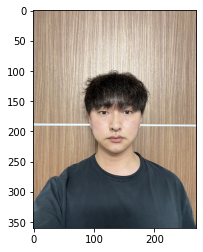

In [3]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb) # 이미지 실제 출력하기 위해 이미지를 올려줌 (원하는 사이즈의 픽셀을 원하는 색으로 채워서 만든 그림이라고 합니다.)
plt.show() # 이미지 실제 출력

정상적으로 출력됨을 확인 할 수 있다.

---
### 얼굴 검출 face detection

Object detection 기술을 이용해서 얼굴의 위치를 찾을 수 있다.  

dlib의 face detector는 HOG(Gistogram of Oriented Gradients)와 SVM(Support Vector Machine)을 사용해서 얼굴을 찾는다.  

HOG는 이미지에서 색상의 변화량을 나타낸 것이다. 색상만으로는 SVM이 좋은 성능을 발휘 할 수 없기 때문에 HOG를 통해 벡터 이미지를 얻는 것이다.  

그럼 dlib을 활용해 hog detector를 선언해 보자.

In [4]:
# detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector() # 기본 얼굴 감지기를 반환

detector_hog를 이용해서 얼굴의 bounding box를 추출한다.

In [5]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

dlib은 rgb 이미지를 입력으로 받기 때문에 cvtColor() 를 이용해서 opencv 의 bgr 이미지를 rgb로 변환해 주었다.

검출한 얼굴을 출력해보자.

rectangles[[(86, 146) (175, 236)]]


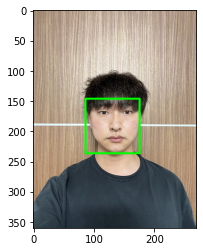

In [6]:
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects)   

for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

dlib detector 는 dlib.rectangles 타입의 객체를 반환한다. dlib.rectangles 는 dlib.rectangle 객체의 배열 형태로 이루어져 있다.

---
## Step 3. 스티커 적용 위치 확인하기

- 고양이 수염이 적용 될 위치를 landmark를 사용해서 계산해 주세요.  
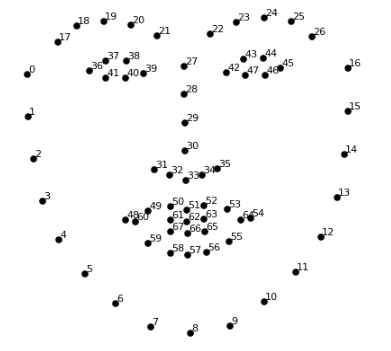  
코 끝인 33 번보다 좋은 위치가 있을 거예요.

---
### 얼굴 랜드마크 face landmark

스티커를 섬세하게 적용하기 위해서는 이목구비의 위치를 아는 것이 중요하다.  
이목구비의 위치를 추론하는 것을 face landmark localization 기술이라고 하는데, face landmark는 detection 의 결과물인 bounding box 로 잘라낸(crop) 얼굴 이미지를 이용한다.  

#### **Object keypoint estimation 알고리즘**

Face landmark와 같이 객체 내부의 점을 찾는 기술을 object keypoint estimation이라 하며, keypoint를 찾는 알고리즘은 크게 2가지로 나누어 진다.

1. top-down : bounding box를 찾고 box 내부의 keypoint를 예측

2. bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성

이번 프로젝트에서는 1번 방식을 다룬다.


---
### dlib landmark localization

크롭된 얼굴 이미지에서 68개의 이목구비 위치를 찾는다.(상단 이미지)  
이 때 점의 갯수는 데이터셋과 논문마다 다르다. 예를 들면, AFLW 데이터셋은 21개를 사용하고, ibug 300w 데이터셋은 68개를 사용한다.  

Dlib은 ibug 300-W 데이터셋으로 학습한 retrained model을 제공하며, 학습 알고리즘은 regression tree의 앙상블 모델을 사용한다. 그럼 이제 Dlib의 제공된 모델을 사용해보자.

In [7]:
model_path = data_dir+'/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
    # 저장한 landmark 모델의 주소를 model_path 변수에 저장
landmark_predictor = dlib.shape_predictor(model_path)
    # dlib 라이브러리의 shape_predictor 함수를 이용하여 모델을 불러옴
    # landmark_predictor는 RGB이미지와 dlib.rectangle를 입력 받고 dlib.full_object_detection를 반환
    # dlib.rectangle: 내부를 예측하는 박스
    # dlib.full_object_detection: 각 구성 요소의 위치와, 이미지 상의 객체의 위치를 나타냄

landmark_predictor는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환한다.

In [8]:
list_landmarks = []
    # 랜드마크의 위치를 저장할 list 생성    

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
# face landmark 좌표를 저장해둡니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
        # 모든 landmark의 위치정보를 points 변수에 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        # 각각의 landmark 위치정보를 (x,y) 형태로 변환하여 list_points 리스트로 저장
    list_landmarks.append(list_points)
        # list_landmarks에 랜드마크 리스트를 저장

print(len(list_landmarks[0]))
    # 얼굴이 n개인 경우 list_landmarks는 n개의 원소를 갖고
    # 각 원소는 68개의 랜드마크 위치가 나열된 list 
    # list_landmarks의 원소가 1개이므로 list_landmarks[1]을 호출하면 IndexError가 발생

68


list_points 는 tuple (x, y) 68개로 이루어진 리스트가 된다. 이미지에서 검출된 얼굴 개수마다 반복하면 list_landmark에 68개의 랜드마크가 얼굴 개수만큼 저장됩니다. 출력을 통해 하나의 얼굴에 대해 68개의 랜드마크가 저장된 것임을 확인 할 수 있다.

그렇다면 랜드마크를 영상에 출력해보자.

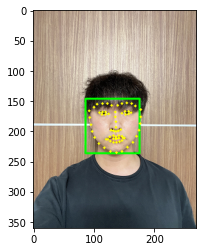

In [9]:
# list_landmarks의 원소가 1개이므로 아래 반복문은 한번만 실행됨
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
            # cv2.circle: OpenCV의 원을 그리는 함수
            # img_show 이미지 위 각각의 point에
            # 크기가 2이고 (0, 255, 255)색으로 내부가 채워진(-1) 원을 그림
            # (마지막 인수가 자연수라면 그만큼의 두께의 선으로 원이 그려짐)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    # RGB 이미지로 전환
plt.imshow(img_show_rgb)
    # 이미지를 준비
plt.show()
    # 이미지를 출력

이로써 스티커를 적용 할 준비가 완료되었다.

---
## Step 4. 스티커 적용하기

1. 오늘 배운 np.where 를 사용해서 스티커를 적용해 주세요.

2. 스티커를 조금 더 자연스럽게 보이게 하려면 어떻게 해야 할까요? 스티커 뒤로 원본 이미지가 같이 보이도록 만들어 봅시다. opencv 의 cv2.addWeighted() 를 참고하세요.

랜드마크를 기준으로 코의 위치에 스티커를 붙이면 될 것 같다.

In [10]:
# zip() : 두 그룹의 데이터를 서로 엮어주는 파이썬의 내장 함수
# dlib_rects와 list_landmarks 데이터를 엮어 주었음
# dlib_rects : 얼굴 영역을 저장하고 있는 값
# list_landmarks : 68개의 랜드마크 값 저장(이목구비 위치(x,y))

for dlib_rect, landmark in zip(dlib_rects, list_landmarks): # 얼굴 영역을 저장하고 있는 값과 68개의 랜드마크를 저장하고 있는 값으로 반복문 실행
    print (landmark[30])
    x = landmark[30][0] 
    y = landmark[30][1] 

    w = h = dlib_rect.width() # 얼굴 영역의 가로를 차지하는 픽셀의 수 (531-345+1) → max(x) - min(x) +1(픽셀의 수 이기 때문에 1을 더해줌 → 픽셀 수는 점 하나로도 1이 됨)
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

#Original code

#    print (landmark[30]) # 코의 index는 30 입니다
#    x = landmark[30][0] # 이미지에서 코 부위의 x값
#    y = landmark[30][1] - dlib_rect.height()//2 # 이미지에서 코 부위의 y값 - 얼굴 영역의 세로를 차지하는 픽셀의 수//2 → (437, 182-(186+1//2)

(136, 193)
(x,y) : (136,193)
(w,h) : (90,90)


코의 좌표를 확인 할 수 있다.

이제 스티커를 준비해보자

In [11]:
sticker_path = data_dir+'/camera_sticker/images/cat-whiskers.png' # 왕관 이미지의 경로
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다 // cv2.imread(이미지 경로) → image객체 행렬을 반환
img_sticker = cv2.resize(img_sticker, (w,h)) # 스티커 이미지 조정 → w,h는 얼굴 영역의 가로를 차지하는 픽셀의 수(187) // cv2.resize(image객체 행렬, (가로 길이, 세로 길이))
print (img_sticker.shape) # 사이즈를 조정한 왕관 이미지의 차원 확인

(90, 90, 3)


이미지를 읽고 윗 단계에서 계산한 크기로 resize 했다.

원본 이미지에 스티커 이미지를 추가하기 위해서 x,y 좌표를 조정한다. 이미지의 시작점은 top-left 좌표이기 때문이다.

In [12]:
# x,y,w,h 모두 위에서 반복문 안에서 지정해준 값임
# x는 이미지에서 코 부위의 x값
# y는 이미지에서 코 부위의 y값
# w는 얼굴 영역의 가로를 차지하는 픽셀의 수
# h는 얼굴 영역의 가로를 차지하는 픽셀의 수
refined_x = x - w // 2 # 437 - (187//2) = 437-93 = 344
refined_y = y - h // 2 # 89-187 = -98
# 원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정합니다. 이미지 시작점은 top-left 좌표이기 때문입니다.
# 즉, refined_x, refined_y값에서 스티커가 시작됨
# 음수 발생 : 이미지 범위를 벗어남
# opencv는 ndarray데이터를 사용하는데, ndarray는 음수인덱스에 접근 불가하므로 스티커 이미지를 잘라 줘야 한다.

- 스티커의 시작점이 얼굴영역 밖으로 벗어나면 음수로 표현된다. ndarray는 음수 인덱스에 접근 할 수 없기 때문에 음수에 대한 예외처리가 필요하다.  
- -y 크기만큼 스티커를 crop 하고, top 의 x좌표와 y 좌표를 각각의 경우에 맞춰 원본 이미지의 경계 값으로 수정한다.

In [13]:
# 왕관 이미지가 이미지 밖에서 시작하지 않도록 조정이 필요함

# 음수값 만큼 왕관 이미지(혹은 추후 적용할 스티커 이미지)를 자른다.
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
# 왕관 이미지를 씌우기 위해 왕관 이미지가 시작할 y좌표 값 조정
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (91,148)


이제 원본 이미지에 스티커를 적용해보자.

In [14]:
# sticker_area는 원본이미지에서 스티커를 적용할 위치를 crop한 이미지 입니다.

# [origin] sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

# 평섭님이 알려준 코드 0 -> 255로 바꾸니 정상적으로 배경이 날아갔다
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

# [origin] img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
# [origin]   np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

sticker_area는 원본 이미지에서 스티커를 적용할 위치를 crop한 이미지다. 스티커 이미지에서 0이 아닌 색이 있는 이미지 부분을 사용하기 때문에 np.where를 이용해 img_sticker가 0인 부분은 sticker_area를 사용하고 0이 아닌 부분을 img_sticker를 사용하는 것이다.

-> 스티커 배경이 자꾸 흰색으로 붙어서 고생했는데 0->255로 값을 바꿈으로써 해결됐다.

img_show에 적용해보자

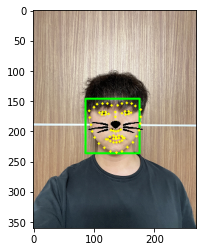

In [15]:
# 왕관 이미지를 적용한 이미지를 보여준다.
# 얼굴 영역(7-3)과 랜드마크(7-4)를 미리 적용해놓은 img_show에 왕관 이미지를 덧붙인 이미지가 나오게 된다.)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

이제 bounding box와 landmark를 제거하고 스티커와 이미지만 출력해보자

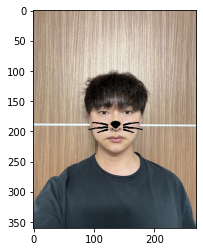

In [16]:
# 위에서 설명했으므로 생략
# 왕관 이미지
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# img_bgr은 7-2에서 rgb로만 적용해놓은 원본 이미지이다. 
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)) # rgb만 적용해놓은 원본 이미지에 왕관 이미지를 덮어 씌운 이미지가 나오게 된다.
plt.show()

완성!

---
## Step 5. 문제점 찾아보기

1. 셀프 카메라를 다양한 각도에서 촬영하면서 스티커를 반복해서 적용해 보세요.

2. 문제점이 무엇인지 최대한 자세하게 기록해 보세요. 여러분이 생각한 문제점을 해결하기 위한 방법은 분명 존재합니다!
>> 오늘 만든 스티커앱에서 생각해볼 수 있는 문제점은 다음과 같습니다.
>
>얼굴 각도에 따라 스티커가 어떻게 변해야할까요?  
멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?  
실행 속도가 중요할까요?  
스티커앱을 만들 때 정확도가 얼마나 중요할까요?  
>


---
### 위에서 열거한 다양한 케이스들을 상정하며 테스트해보자

1. 30' 90' 고개를 돌려서 확인

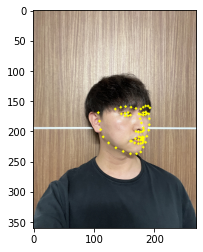

In [17]:
# 이미지 로드
my_image_path = data_dir+'/camera_sticker/images/30.png' # 본인 이미지가 있는 경로를 가지고 온다.
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다

# 색 복원
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# bounding box 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)

# landmark 추출
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

# landmark가 표시된 이미지 출력
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

landmark 생성 완료. 얼굴 인식에 문제가 없는 것으로 판단된다.

(181, 194)
(x,y) : (181,194)
(w,h) : (90,90)


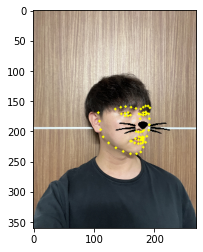

In [18]:
# 코 좌표 계산
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30])
    x = landmark[30][0]
    y = landmark[30][1]
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

# 스티커 준비
sticker_path = data_dir+'/camera_sticker/images/cat-whiskers.png' # 스티커 경로
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))


# 좌표 조정
refined_x = x - w // 2
refined_y = y - h // 2 

# 예외처리
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

# 이미지에 스티커 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

# 적용한 이미지 확인
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

결과 확인

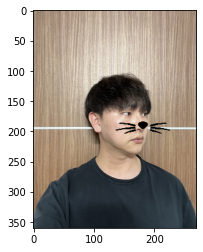

In [19]:
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# img_bgr은 7-2에서 rgb로만 적용해놓은 원본 이미지이다. 
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)) # rgb만 적용해놓은 원본 이미지에 왕관 이미지를 덮어 씌운 이미지가 나오게 된다.
plt.show()

30'로 고개를 돌린 사진에서는 어쨋거나 잘 붙었다.

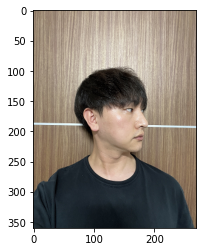

In [20]:
# 이미지 로드
my_image_path = data_dir+'/camera_sticker/images/90.png' # 본인 이미지가 있는 경로를 가지고 온다.
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다

# 색 복원
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# bounding box 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)

# landmark 추출
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

# landmark가 표시된 이미지 출력
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

90'로 고개를 돌린 사진에서는 landmark 생성단계에서부터 fail.  
얼굴 인식에 문제가 있는 것 같다. 30'로 돌린 이전 사진과의 차이는 눈이 하나밖에 안보인다는 점이 거의 유일한 차이점이다.

그렇다면 얼굴이 온전하게 정면을 바라보는 상태에서 반쪽 얼굴만 보이게 crop된 사진의 경우는 어떨까?

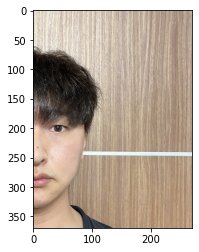

In [21]:
# 이미지 로드
my_image_path = data_dir+'/camera_sticker/images/crop.png' # 본인 이미지가 있는 경로를 가지고 온다.
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다

# 색 복원
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# bounding box 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)

# landmark 추출
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

# landmark가 표시된 이미지 출력
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

마찬가지로 얼굴을 인식 할 수 없다. landmark가 얼굴의 윤곽 - 눈 - 코 - 입에 생성되는 것으로 미루어 짐작하건데 열거한 요소들이 전부 사진에 포함되어야 하는 것으로 유추 할 수 있다.

그렇다면, 모든 요소가 온전 할 때 사진이 90' / 180'로 rotate 되었을 때는 어떨까?

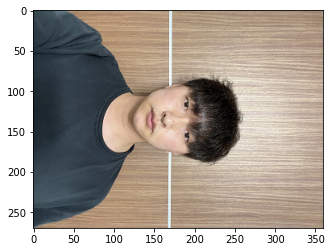

In [22]:
# 이미지 로드
my_image_path = data_dir+'/camera_sticker/images/rotate90.png' # 본인 이미지가 있는 경로를 가지고 온다.
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다

# 색 복원
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# bounding box 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)

# landmark 추출
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

# landmark가 표시된 이미지 출력
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

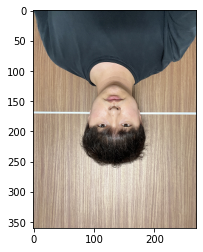

In [23]:
# 이미지 로드
my_image_path = data_dir+'/camera_sticker/images/rotate180.png' # 본인 이미지가 있는 경로를 가지고 온다.
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다

# 색 복원
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# bounding box 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)

# landmark 추출
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

# landmark가 표시된 이미지 출력
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

인식되지 않는 것을 확인 할 수 있다. 사용된 모델이 얼굴을 검출하기 위해서는 어느정도 정형화된 컨디션이어야 가능한 것으로 예상 할 수 있다.
1. 온전한 얼굴 전체가 보여야함
2. 이목구비와 얼굴윤곽이 보여야함
3. 수평적인 수준을 일정 유지해야함


그 밖의 다양한 case에 대해 얼굴 검출을 시도해보자

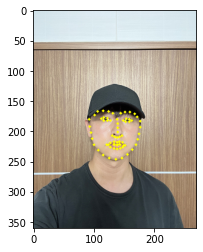

In [24]:
# 이미지 로드
my_image_path = data_dir+'/camera_sticker/images/onlycap.png' # 본인 이미지가 있는 경로를 가지고 온다.
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다

# 색 복원
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# bounding box 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)

# landmark 추출
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

# landmark가 표시된 이미지 출력
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

모자만 쓴 경우에는 정상적으로 검출되었다. 그렇다면 코와 입이 가려지게끔 마스크를 쓴 경우는?

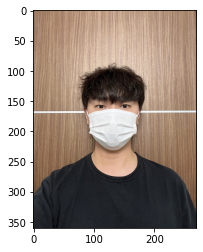

In [25]:
# 이미지 로드
my_image_path = data_dir+'/camera_sticker/images/masked.png' # 본인 이미지가 있는 경로를 가지고 온다.
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다

# 색 복원
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# bounding box 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)

# landmark 추출
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

# landmark가 표시된 이미지 출력
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

예상대로 검출에 실패했다.

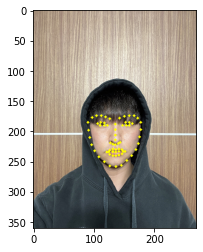

In [26]:
# 이미지 로드
my_image_path = data_dir+'/camera_sticker/images/hoody.png' # 본인 이미지가 있는 경로를 가지고 온다.
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다

# 색 복원
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# bounding box 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)

# landmark 추출
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

# landmark가 표시된 이미지 출력
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

(135, 214)
(x,y) : (135,214)
(w,h) : (90,90)


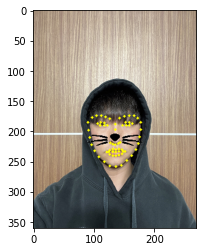

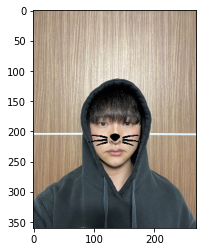

In [27]:
# 코 좌표 계산
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30])
    x = landmark[30][0]
    y = landmark[30][1]
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

# 스티커 준비
sticker_path = data_dir+'/camera_sticker/images/cat-whiskers.png' # 스티커 경로
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))


# 좌표 조정
refined_x = x - w // 2
refined_y = y - h // 2 

# 예외처리
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

# 이미지에 스티커 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

# 적용한 이미지 확인
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# img_bgr은 7-2에서 rgb로만 적용해놓은 원본 이미지이다. 
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)) # rgb만 적용해놓은 원본 이미지에 왕관 이미지를 덮어 씌운 이미지가 나오게 된다.
plt.show()

후드를 쓰더라도 얼굴 윤곽이 보이는 정도라서 검출에 문제가 없었다.  
여러가지 case를 확인하다 보니 처음 가설로 설정했던 조건들이 어느정도 확실한 듯 하다.

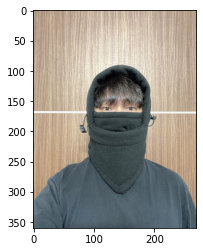

In [28]:
# 이미지 로드
my_image_path = data_dir+'/camera_sticker/images/thief.png' # 본인 이미지가 있는 경로를 가지고 온다.
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다

# 색 복원
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# bounding box 추출
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)

# landmark 추출
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

# landmark가 표시된 이미지 출력
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

도둑 검거 실패

---
## Step 06. 마치며

1. 상용화된 카메라 어플이 스티커를 붙여줄 때 어떤 방식으로 작동하는지 모델을 이용하여 재밌게 접근 할 수 있었다.  
2. 고양이 코와 수염의 정확한 위치를 찾기 위해서 x y 값을 설정해주며 좌표평면상에서 스티커가 어떻게 위치하는지 알 수 있었다.
3. 결과적으로 코 끝인 33번보다 30번에서 얼굴의 중심인만큼 x, y를 각각 얼굴 비율에서 절반씩 shift 해주니 결과적으로 자연스러운 위치에 붙일 수 있었다.
4. 얼굴의 수직/수평기준으로 회전해보거나 장애물(모자, 후드, 마스크)등으로 이미지에 변화를 줌으로써 모델이 얼굴을 검출하는데 어떤 조건들이 있는지 가늠해볼 수 있었다.(얼굴이 정면을 향할 것/이목구비와 얼굴 윤곽이 보일 것/T존이 수평이어야 할 것 등)
5. NLP보다 CV가 더 취향에 맞는지 지난번 프로젝트보다 더 재밌게 진행 할 수 있었다. 하지만 앞으로 각각 몇번씩은 더 학습 할 예정이니 편식하지말고 골고루 학습해야겠다😊
